In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ['LANGCHAIN_API_KEY'] = 'xx'
os.environ['LANGCHAIN_ENDPOINT'] = "https://api.smith.langchain.com"
os.environ['OPENAI_API_KEY'] = 'xxx'
os.environ['ZHIPUAI_API_KEY'] = 'xxx'
pdf_path = 'your_pdf_path/deepseek-r1-report.pdf'


使用langchain简单实现单轮rag对话（Retrieval-Augmented Generation）

1. 可解释性——能直接看出模型引用的信息源

2. 数据安全——降低训练数据隐私泄露风险

3. 避免重新训练, 数据时效性



# 环境配置

除了基础python库外，还需安装以下依赖：
```
langchain                 0.3.14                   pypi_0    pypi
langchain-community       0.3.14                   pypi_0    pypi
langchain-core            0.3.29                   pypi_0    pypi
langchain-openai          0.2.14                   pypi_0    pypi
langchain-text-splitters  0.3.5                    pypi_0    pypi
langchainhub              0.1.21                   pypi_0    pypi
langgraph                 0.2.61                   pypi_0    pypi
langgraph-checkpoint      2.0.9                    pypi_0    pypi
langgraph-sdk             0.1.51                   pypi_0    pypi
langsmith                 0.2.10                   pypi_0    pypi
```


In [26]:
#引入环境变量和package
from openai import OpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_openai import ChatOpenAI
import bs4
from langchain import hub
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import START, StateGraph
from typing_extensions import List, TypedDict
from langchain_community.embeddings import ZhipuAIEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
import faiss
from uuid import uuid4
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from typing import Dict, List, Tuple, Union
import tiktoken

# Loader
获取各种格式的数据，转成document类型

可以使用GROBID读取科研论文pdf

GROBID的配置有些麻烦，也可以使用pyPDF等

```python
from langchain_community.document_loaders import PyPDFLoader
def load_pdf_file(pdf_path):
    # Load and chunk contents of the PDF file
    loader = PyPDFLoader(file_path=pdf_path)
    for doc in loader.lazy_load():
        yield doc
```

## GROBID配置

使用docker配置，首先去下载docker

docker pull lfoppiano/grobid:0.8.1

然后启动docker

docker run --rm --init --ulimit core=0  -p 8070:8070 lfoppiano/grobid:0.8.1

出现以下信息：

[Wapiti] Loading model: "/opt/grobid/grobid-home/models/funding-acknowledgement/model.wapiti"
Model path: /opt/grobid/grobid-home/models/funding-acknowledgement/model.wapiti

之后不要退出终端，服务已经在http://localhost:8070 启动

In [27]:
from langchain_community.document_loaders.parsers import GrobidParser
from langchain_community.document_loaders.generic import GenericLoader
#Produce chunks from article paragraphs

In [ ]:
## PyPDF
class myPDFReader:
    def __init__(self, file_path):
        self.file_path = file_path
    
    def pypdf_load(self):
        loader = PyPDFLoader(file_path=pdf_path)
        docs = []
        for doc in loader.lazy_load():
            docs.append(doc)
        return docs
    
    def grobid_load(self, **kwargs):
        segment_sentences = kwargs.get('segment_sentences', False)
        loader = GenericLoader.from_filesystem(
            pdf_path,
            glob="*",
            suffixes=[".pdf"],
            parser= GrobidParser(segment_sentences=segment_sentences)
        )
        docs = loader.load()
        return docs
    
    def load_pdf(self, type, **kwargs)->List[Document]:
        if type == 'pypdf':
            return self.pypdf_load(**kwargs)
        elif type == 'grobid':
            return self.grobid_load(**kwargs)
        else:
            raise ValueError("Invalid loader type")
    

pdf_reader = myPDFReader(pdf_path)
docs_grobid = pdf_reader.load_pdf(type='grobid')



In [36]:
len(docs_grobid[3].page_content)

#Document类型： metadata + page_content


389

## Splitter

把pdf文件切分成多个小文件，每个小文件是一个chunk，大小可以自己设置


In [37]:
class mySplitter:
    def __init__(self, chunk_size, overlap_size, use_token_split=True, encoding_name="cl100k_base"):
        self.chunk_size = chunk_size
        self.overlap_size = overlap_size
        self.use_token_split = use_token_split
        self.encoding_name = encoding_name
        if use_token_split:
            self.text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(encoding_name=encoding_name, chunk_size=chunk_size, chunk_overlap=overlap_size)
        else:
            self.text_splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=overlap_size)  #'/n/n'  '/n'  ' '

    def split_docs(self, docs):
        all_splits = self.text_splitter.split_documents(docs)
        return all_splits

splitter = mySplitter(chunk_size=512, overlap_size=16, use_token_split=True, encoding_name="cl100k_base")
split_docs = splitter.split_docs(docs_grobid)

In [44]:
len(split_docs)

69

## Indexer

创建索引

In [ ]:
#首先定义索引需要的embedding模型
text_dimension = 2048
from langchain_community.embeddings import ZhipuAIEmbeddings
embedding_model = ZhipuAIEmbeddings(
    model="embedding-3",
    #api_key=os.environ['ZHIPUAI_API_KEY'],
    dimensions=text_dimension
)
#这里注意
#zhipuAI embedding在调用add_documents时最大允许的文档数是64，所以要分批add
#向量维度默认为 2048，Embedding-3模型支持自定义向量维度，建议选择256、512、1024或2048维度。
#数组总长度<8K, 单条请求最多支持3072 tokens

In [45]:
def split_array(arr:list[Document], single_array_size:int)->list[list[Document]]:
    # 使用列表切片按 single_array_size 拆分list
    # 因为zhipuAI embedding在调用add_documents时最大允许的文档数是64，所以要分批add
    return [arr[i:i + single_array_size] for i in range(0, len(arr), single_array_size)]
splits_docs = split_array(split_docs, 64) #list --> list[list[Document]]

#index
for i, docs in enumerate(splits_docs):
    if i == 0:
        vectordb = FAISS.from_documents(documents=docs, embedding=embedding_model)
    else:
        vectordb.add_documents(documents=docs)

## Retrieve

按照某种规则，从docs中取出和问题相关的部分

In [46]:
from langchain.prompts import PromptTemplate
import logging
from langchain_core.output_parsers import BaseOutputParser
from langchain_community.chat_models import ChatZhipuAI
from langchain.retrievers.multi_query import MultiQueryRetriever
# Output parser will split the LLM result into a list of queries
class LineListOutputParser(BaseOutputParser[List[str]]):
    """Output parser for a list of lines."""

    def parse(self, text: str) -> List[str]: #自定义parser只需要重载parse函数
        lines = text.strip().split("\n")
        return list(filter(None, lines))  # Remove empty lines
    
output_parser = LineListOutputParser()

QUERY_PROMPT = PromptTemplate(
    input_variables=["question"],
    template="""你是一名 AI 语言模型助手。你的任务是：阅读用户的问题，生成5个不同版本的问题，以便从向量数据库中检索相关文档。
    你的目标是，生成用户问题的多个视角，帮助用户克服基于距离的相似性搜索的一些限制。备选问题以换行符隔开。
    原始问题: {question}""",
)
gen_model = ChatZhipuAI(
    model="glm-4-plus",
    temperature=0.5,
)
generate_questions_chain = QUERY_PROMPT | gen_model | output_parser
logging.basicConfig()
logging.getLogger("langchain.retrievers.multi_query").setLevel(logging.INFO) #输出multi_query的中间信息
retriever = MultiQueryRetriever(
    retriever=vectordb.as_retriever(search_type="mmr",search_kwargs={"k": 5, "lambda_mult":0.8}),  
    llm_chain=generate_questions_chain, parser_key="lines" #输出以'\n'分隔，是列表；  其他参数: json, comma
)

In [47]:
question = "请介绍这一篇技术报告的主要内容。"
docs = retriever.invoke(question)
from langchain_community.document_transformers import LongContextReorder
reordering = LongContextReorder()
docs = reordering.transform_documents(docs)
context = ""
for doc in docs:
    context += doc.page_content

answer_llm = ChatZhipuAI(
        model='glm-4-plus',
        temperature=0.1,
    )
answer = answer_llm.invoke(f"基于以下信息回答问题：{question}, 信息如下：{context}")
print(answer.content)

INFO:langchain.retrievers.multi_query:Generated queries: ['1. 这篇技术报告涵盖了哪些关键主题和要点？', '2. 请概述这篇技术报告的核心内容和主要发现。', '3. 这篇技术报告的主要议题和结论是什么？', '4. 能否详细说明这篇技术报告所探讨的主要问题和研究成果？', '5. 这篇技术报告的主要结构和重点内容有哪些？']


这篇技术报告主要介绍了DeepSeek-R1模型的研究进展、存在的问题以及未来的改进方向。以下是报告的主要内容：

### 1. **可读性（Readability）**
- **问题**：DeepSeek-R1-Zero生成的内容不适合阅读，可能混合多种语言，缺乏Markdown格式。
- **改进**：在DeepSeek-R1的冷启动数据设计中，采用可读性模式，包括在每条回复末尾添加总结，并过滤掉不友好的回复。输出格式定义为`|special_token|<reasoning_process>|special_token|<summary>`。

### 2. **潜力（Potential）**
- **观察**：通过精心设计带有人类先验的冷启动数据模式，DeepSeek-R1表现优于DeepSeek-R1-Zero。
- **未来方向**：探索如何利用更长的CoT（Chain of Thought）来增强相关领域的任务。

### 3. **语言混合（Language Mixing）**
- **问题**：DeepSeek-R1目前优化了中文和英文，处理其他语言查询时可能出现语言混合问题。
- **改进方向**：未来更新中将解决这一限制。

### 4. **提示工程（Prompting Engineering）**
- **问题**：DeepSeek-R1对提示敏感，少量提示（few-shot prompting）会降低性能。
- **建议**：推荐用户直接描述问题并指定输出格式，使用零样本设置（zero-shot setting）以获得最佳结果。

### 5. **软件工程任务（Software Engineering Tasks）**
- **问题**：由于评估时间过长，影响RL过程效率，大规模RL在软件工程任务中应用有限，DeepSeek-R1在软件工程基准上改进不大。
- **改进方向**：通过在软件工程数据上实施拒绝采样或在RL过程中引入异步评估来提高效率。

### 6. **结论**
- **结论一**：将更强大的模型蒸馏到小模型中效果优异，而小模型依赖大规模RL需要巨大计算力，且性能可能不如蒸馏。
- **结论二**：蒸馏策略经济有效，但要突破智能边界，仍需更强大的基础模型和更大规模强化学习。

### 7. **基准测试（Benchmar

Maximal Marginal Relevance

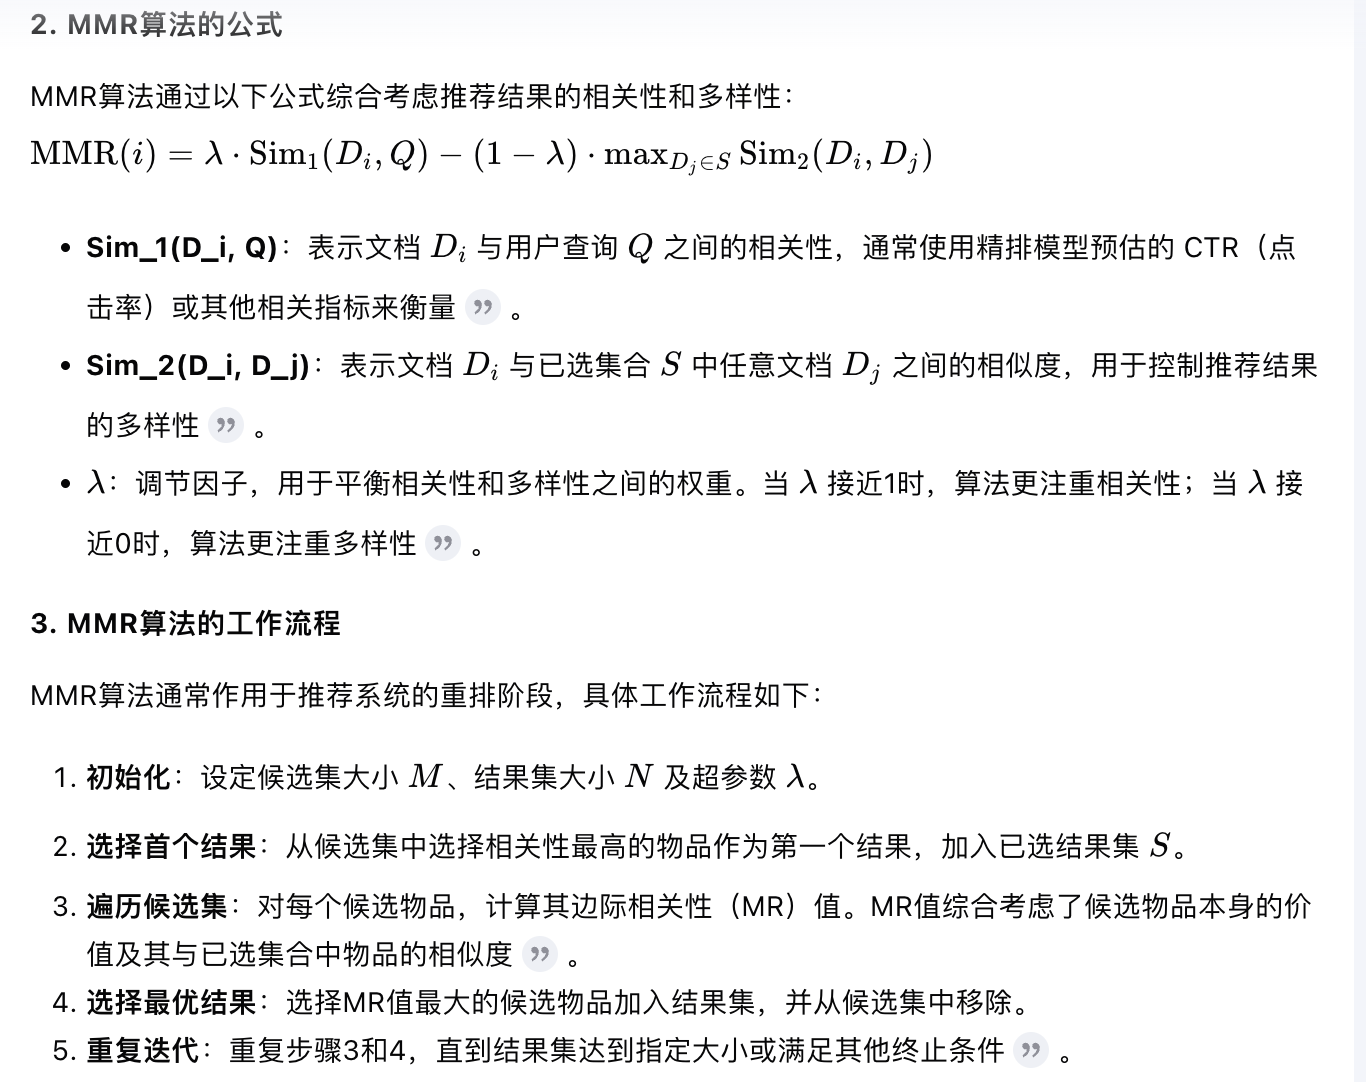

In [52]:
for tokn in answer_llm.stream(f"基于以下信息回答问题：{question}, 信息如下：{context}"):
    print(tokn.content,end="")

这篇技术报告主要介绍了DeepSeek-R1模型的研究进展、存在的问题以及未来的改进方向。以下是报告的主要内容：

### 1. **可读性改进**
- **问题**：DeepSeek-R1-Zero生成的内容不适合阅读，可能混合多种语言，缺乏Markdown格式。
- **解决方案**：设计了一种可读性强的模式，包括在每个回答末尾添加总结，并过滤掉不友好的回答。输出格式定义为`|special_token|<reasoning_process>|special_token|<summary>`。

### 2. **潜力与性能提升**
- **观察**：通过精心设计带有人类先验的冷启动数据模式，DeepSeek-R1表现优于DeepSeek-R1-Zero。
- **未来方向**：探索如何利用更长的CoT（Chain of Thought）来提升任务性能。

### 3. **语言混合问题**
- **问题**：DeepSeek-R1目前优化了中文和英文，处理其他语言查询时可能出现语言混合问题。
- **未来改进**：计划在后续更新中解决这一限制。

### 4. **提示工程**
- **发现**：DeepSeek-R1对提示敏感，少样本提示会降低性能。
- **建议**：使用零样本设置直接描述问题并指定输出格式以获得最佳结果。

### 5. **软件工程任务**
- **问题**：由于评估时间过长，大规模RL在软件工程任务中应用有限，DeepSeek-R1在软件工程基准上改进不大。
- **未来改进**：通过实施拒绝采样或异步评估来提高效率。

### 6. **模型蒸馏与RL训练**
- **结论**：
  - 蒸馏更强大的模型到小模型效果优异，而小模型依赖大规模RL需要巨大计算资源，性能可能不如蒸馏。
  - 蒸馏策略经济有效，但要突破智能边界仍需更强大的基础模型和更大规模的RL。

### 7. **基准测试**
- **评估基准**：包括MMLU、MMLU-Redux、MMLU-Pro、C-Eval、CMMLU、IFEval、FRAMES、GPQA Diamond、SimpleQA、C-SimpleQA、SWE-Bench Verified、Aiderfoot_0、LiveCodeBench、Codeforces、CNMO 2024、AIME 202

In [48]:
print(context)

In the future, we plan to invest in research across the following directions for DeepSeek-R1.• Readability: A key limitation of DeepSeek-R1-Zero is that its content is often not suitable for reading.Responses may mix multiple languages or lack markdown formatting to highlight answers for users.In contrast, when creating cold-start data for DeepSeek-R1, we design a readable pattern that includes a summary at the end of each response and filters out responses that are not reader-friendly.Here, we define the output format as |special_token|<reasoning_process>|special_token|<summary>, where the reasoning process is the CoT for the query, and the summary is used to summarize the reasoning results.• Potential: By carefully designing the pattern for cold-start data with human priors, we observe better performance against DeepSeek-R1-Zero.We believe the iterative training is a better way for reasoning models.Moving forward, we plan to explore how long CoT can be leveraged to enhance tasks in t